### Building a Convolutional Neural Network Using PyTorch to Classify CIFAR10


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torchvision import transforms as T, datasets

In [3]:
train_ds = datasets.CIFAR10('cifar10/',train = True,
                            download = True,
                            transform = T.ToTensor()) #Load Dataset with only ToTensor Transform

Files already downloaded and verified


In [4]:
# Collect or append all the images in one empty list

train_imgs = torch.stack([train_imgs_t for train_imgs_t,_ in train_ds],dim = 3)

In [5]:
# 3,32,32,50000 -> 3,32*32*50000 -> mean

train_imgs.view(3,-1).mean(dim = 1)

tensor([0.4914, 0.4822, 0.4465])

In [6]:
# 3,32,32,50000 -> 3,32*32*50000 ->std

train_imgs.view(3,-1).std(dim = 1)

tensor([0.2470, 0.2435, 0.2616])

**Load CIFAR-10 Dataset**

In [7]:
data_transforms = T.Compose([
    T.ToTensor(), # H x W x C-> C x H x W
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

In [8]:
# train_ds = datasets.CIFAR10('cifar10/', train=True, download = True, transform = data_transforms)
test_ds = datasets.CIFAR10('cifar10/', train=False, download = True, transform = data_transforms)

Files already downloaded and verified


In [9]:
print('Size of train set {}'.format(len(train_ds)))
print('Size of test set {}'.format(len(test_ds)))

Size of train set 50000
Size of test set 10000


**Plot examples from dataset**

In [10]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

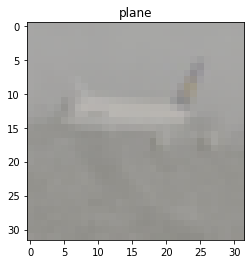

In [11]:
index = 199
image, label = train_ds[index]
image = image.permute(1,2,0) # C(0) x H(1) x W(2)

#denormalizing the image
image = image * torch.Tensor([0.2470, 0.2435, 0.2616]) + torch.Tensor([0.4914, 0.4822, 0.4465])
plt.imshow(image)
plt.title(classes[label]);

**Load dataset into batches**

In [12]:
from torch.utils.data import DataLoader, random_split

In [13]:
train_dataset, valid_dataset = random_split(train_ds, (45000, 5000))

In [14]:
trainLoader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validLoader = DataLoader(valid_dataset, batch_size = 64, shuffle = True)
testLoader = DataLoader(test_ds, batch_size = 64, shuffle = True)

In [15]:
print("total batches created in Train loader: {}".format(len(trainLoader)))
print("total batches created in Valid loader: {}".format(len(validLoader)))
print("total batches created in Test loader: {}".format(len(testLoader)))
print("size of train dataset {}".format(len(trainLoader.dataset)))
print("size of valid dataset {}".format(len(validLoader.dataset)))
print("size of test dataset {}".format(len(testLoader.dataset)))

total batches created in Train loader: 704
total batches created in Valid loader: 79
total batches created in Test loader: 157
size of train dataset 45000
size of valid dataset 5000
size of test dataset 10000


In [16]:
detailer = iter(trainLoader)

images, labels = detailer.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


**Create Convolutional Neural Network**

In [17]:
from torch import nn
import torch.nn.functional as F


k : kernel_size or filters 
<br>
p : padding 
<br>
s : stride 
<br>
W : Width 
<br>
H : Height 

\begin{equation*}
For Same padding = \frac{k - 1}{2} \\
\end{equation*}

\begin{equation*}
W[next] = \frac{W[previous] + 2p - k}{s} + 1 \\
\end{equation*}

\begin{equation*}
H[next] = \frac{H[previous] + 2p - k}{s} + 1 \\
\end{equation*}

In [18]:
'''
3 x 32 x 32 (input)

       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1
       V activation = relu 
       
16 x 32 x 32

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
16 x 15 x 15

       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2
       V activation = relu
       
32 x 15 x 15 

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
32 x 8 x 8

       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3
       V activation = relu 
       
64 x 8 x 8

       | k = (2,2), s = 2 , operation = MaxPooling #maxpool
       V

64 x 4 x  4
    
       |  operation = Flatten
       V
500

       |  linear,activation = relu #linear1
       V

128
       |  linear,activation = relu #linear2
       V

10  linear, activation = log_softmax #linear3
'''

'\n3 x 32 x 32 (input)\n\n       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1\n       V activation = relu \n       \n16 x 32 x 32\n\n       | k = (2,2), s = 2, operation = Max Pooling #maxpool\n       V \n       \n16 x 15 x 15\n\n       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2\n       V activation = relu\n       \n32 x 15 x 15 \n\n       | k = (2,2), s = 2, operation = Max Pooling #maxpool\n       V \n       \n32 x 8 x 8\n\n       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3\n       V activation = relu \n       \n64 x 8 x 8\n\n       | k = (2,2), s = 2 , operation = MaxPooling #maxpool\n       V\n\n64 x 4 x  4\n    \n       |  operation = Flatten\n       V\n500\n\n       |  linear,activation = relu #linear1\n       V\n\n128\n       |  linear,activation = relu #linear2\n       V\n\n10  linear, activation = log_softmax #linear3\n'

In [19]:
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels = 16,
                               kernel_size = (3,3), padding =1, stride = 1)
        
        self.conv_2 = nn.Conv2d(in_channels = 16, out_channels = 32,
                               kernel_size = (3,3), padding =1, stride = 1)
        
        self.conv_3 = nn.Conv2d(in_channels = 32, out_channels = 64,
                               kernel_size = (3,3), padding =1, stride = 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size =(2,2), stride = 2)
        self.linear_1 = nn.Linear(in_features = 1024, out_features = 500)
        self.linear_2 = nn.Linear(in_features = 500, out_features = 128)
        self.linear_3 = nn.Linear(in_features = 128, out_features = 10)
        
        
    def forward(self, images):
        
        #images : 3 x 32 x32
        
        a1 = self.maxpool(F.relu(self.conv_1(images)))
        a2 = self.maxpool(F.relu(self.conv_2(a1)))
        a3 = self.maxpool(F.relu(self.conv_3(a2)))
        
        a3 = a3.view(a3.shape[0], -1) #(bs, 64, 4, 4) -> (bs, 64*4*4) -> (bs, 1024)
        
        a4 = F.relu(self.linear_1(a3))
        
        a5 = F.relu(self.linear_2(a4))
        
        a6 = F.log_softmax(self.linear_3(a5))
        
        return(a6)

In [20]:
model = MyModel()
model

MyModel(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=500, bias=True)
  (linear_2): Linear(in_features=500, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=10, bias=True)
)

In [21]:
from torchsummary import summary

In [22]:
summary(model, input_size= (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 500]         512,500
            Linear-8                  [-1, 128]          64,128
            Linear-9                   [-1, 10]           1,290
Total params: 601,502
Trainable params: 601,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.29
Estimated Total Size (MB): 2.58
-------------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**Training loop**

In [23]:
from torch import optim
from utils import multiclass_accuracy
from tqdm import tqdm

criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 10

In [24]:
for i in range(epochs):
    
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0
    
    model.train()
    
    for images, labels in tqdm(trainLoader):
        
        logps = model(images) #output ps
        
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() #w = w - lr*dw
        
        train_loss += loss.item()
        ps = torch.exp(logps) #log_softmax -> softmax
        train_acc += multiclass_accuracy(ps,labels)
        
    model.eval() 
    
    for images, labels in tqdm(validLoader):
        
        logps = model(images)
        logs = criterion(logps, labels)
        
        valid_loss += loss.item()
        ps = torch.exp(logps)
        valid_acc += multiclass_accuracy(ps, labels)
        
    avg_train_loss = train_loss/len(trainLoader)
    avg_valid_loss = valid_loss/len(validLoader)
    avg_train_acc = train_acc/len(trainLoader)
    avg_valid_acc = valid_acc/len(validLoader)

    print("Epoch: {} Train loss: {: .4f} Train Acc : {:.4f}".format(i, avg_train_loss, avg_train_acc))
    print("Epoch: {} Valid loss: {: .4f} Valid Acc : {:.4f}".format(i, avg_valid_loss, avg_valid_acc))

100%|██████████| 79/79 [00:02<00:00, 32.79it/s]


Epoch: 0 Train loss:  1.7560 Train Acc : 0.3456
Epoch: 0 Valid loss:  1.3560 Valid Acc : 0.4555


100%|██████████| 79/79 [00:02<00:00, 33.36it/s]


Epoch: 1 Train loss:  1.3414 Train Acc : 0.5108
Epoch: 1 Valid loss:  1.5350 Valid Acc : 0.4974


100%|██████████| 79/79 [00:02<00:00, 33.35it/s]


Epoch: 2 Train loss:  1.1937 Train Acc : 0.5697
Epoch: 2 Valid loss:  0.9821 Valid Acc : 0.5635


100%|██████████| 79/79 [00:02<00:00, 32.88it/s]


Epoch: 3 Train loss:  1.1044 Train Acc : 0.6048
Epoch: 3 Valid loss:  0.9941 Valid Acc : 0.6080


100%|██████████| 79/79 [00:02<00:00, 32.94it/s]


Epoch: 4 Train loss:  1.0459 Train Acc : 0.6276
Epoch: 4 Valid loss:  1.3702 Valid Acc : 0.6121


100%|██████████| 79/79 [00:02<00:00, 33.03it/s]


Epoch: 5 Train loss:  0.9937 Train Acc : 0.6449
Epoch: 5 Valid loss:  1.6702 Valid Acc : 0.6232


100%|██████████| 79/79 [00:02<00:00, 32.66it/s]


Epoch: 6 Train loss:  0.9528 Train Acc : 0.6627
Epoch: 6 Valid loss:  0.6695 Valid Acc : 0.6084


100%|██████████| 79/79 [00:02<00:00, 33.08it/s]


Epoch: 7 Train loss:  0.9064 Train Acc : 0.6777
Epoch: 7 Valid loss:  1.1022 Valid Acc : 0.6331


100%|██████████| 79/79 [00:02<00:00, 32.77it/s]


Epoch: 8 Train loss:  0.8792 Train Acc : 0.6872
Epoch: 8 Valid loss:  0.6762 Valid Acc : 0.6406


100%|██████████| 79/79 [00:02<00:00, 33.15it/s]

Epoch: 9 Train loss:  0.8473 Train Acc : 0.6974
Epoch: 9 Valid loss:  1.6022 Valid Acc : 0.6365


**Evaluate model**

In [25]:
from utils import view_classify

In [26]:
test_loss = 0
test_acc = 0

model.eval()

for images, labels in tqdm(testLoader):
        
        logps = model(images)
        logs = criterion(logps, labels)
        
        test_loss += loss.item()
        ps = torch.exp(logps)
        test_acc += multiclass_accuracy(ps, labels)
        

avg_test_loss = test_loss/len(testLoader)
avg_test_acc = test_acc/len(testLoader)

print('Test loss: {:.4f} test Acc: {:.4f}'.format(avg_test_loss, avg_test_acc))
        

100%|██████████| 157/157 [00:05<00:00, 27.50it/s]

Test loss: 1.6022 test Acc: 0.3641


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


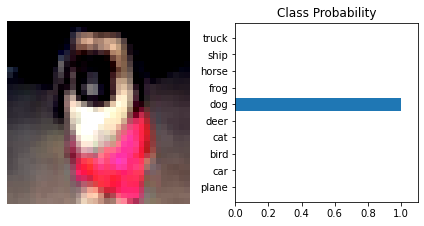

In [27]:
detailer = iter(testLoader)

images, labels = detailer.next()

index = 35
logps = model(images[index].unsqueeze(0)) # (3, 32, 32) -> (1, 3, 32, 32)
ps = torch.exp(logps)

view_classify(images[index], ps)